# Importin Dataset

In [18]:
import tensorflow as tf
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

f'Train data: Shape={x_train.shape}, Min={np.min(x_train)}, Max={np.max(x_train)}, Test Shape: {x_test.shape}, Targets: {np.unique(y_train)}'

'Train data: Shape=(60000, 28, 28), Min=0, Max=255, Test Shape: (10000, 28, 28), Targets: [0 1 2 3 4 5 6 7 8 9]'

# Preprocessing Dataset

In [19]:
x_train = np.expand_dims(x_train, axis=-1)/255.0
x_test = np.expand_dims(x_test, axis=-1)/255.0
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

f'Train data: Shape={x_train.shape}, Min={np.min(x_train)}, Max={np.max(x_train)}, Test Shape: {x_test.shape}, Targets: {y_train.shape}'

'Train data: Shape=(60000, 28, 28, 1), Min=0.0, Max=1.0, Test Shape: (10000, 28, 28, 1), Targets: (60000, 10)'

# Building Custom LeNet CNN Model

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=x_train.shape[1:]),
    tf.keras.layers.RandomRotation(factor=0.1),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='gelu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='gelu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding='same', activation='gelu'),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='gelu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='gelu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='same', activation='gelu'),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='same', activation='gelu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 conv2d_21 (Conv2D)          (None, 26, 26, 32)        288       
                                                                 
 batch_normalization_12 (Bat  (None, 26, 26, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_22 (Conv2D)          (None, 24, 24, 32)        9216      
                                                                 
 batch_normalization_13 (Bat  (None, 24, 24, 32)       128       
 chNormalization)                                                
                                                      

# Training

In [21]:
import tensorflow_addons as tfa

model.compile(
    optimizer=tfa.optimizers.Yogi(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

batch_size = 32
epochs = 200

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='checkpoint/mnist_cnn_callback.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=50,
        verbose=1,
        restore_best_weights=True
    ),
    tf.keras.callbacks.TensorBoard(
        log_dir='checkpoint',
        write_graph=False
    )
]

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(x_test, y_test)
)

Epoch 1/200
1875/1875 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.9438
Epoch 1: val_loss improved from inf to 0.55356, saving model to checkpoint\mnist_cnn_callback.h5
1875/1875 [==============================] - 198s 104ms/step - loss: 0.6777 - accuracy: 0.9438 - val_loss: 0.5536 - val_accuracy: 0.9863
Epoch 2/200
1875/1875 [==============================] - ETA: 0s - loss: 0.5714 - accuracy: 0.9810
Epoch 2: val_loss improved from 0.55356 to 0.53308, saving model to checkpoint\mnist_cnn_callback.h5
1875/1875 [==============================] - 201s 107ms/step - loss: 0.5714 - accuracy: 0.9810 - val_loss: 0.5331 - val_accuracy: 0.9920
Epoch 3/200
1875/1875 [==============================] - ETA: 0s - loss: 0.5563 - accuracy: 0.9852
Epoch 3: val_loss improved from 0.53308 to 0.53013, saving model to checkpoint\mnist_cnn_callback.h5
1875/1875 [==============================] - 186s 99ms/step - loss: 0.5563 - accuracy: 0.9852 - val_loss: 0.5301 - val_accuracy: 0

# Plotting Training Progress

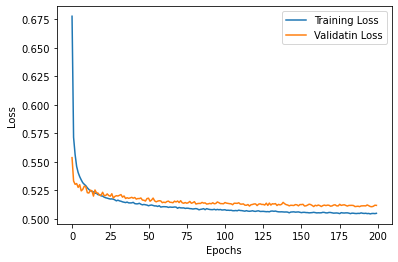

In [22]:
import matplotlib.pyplot as plt

history_dict = history.history

plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validatin Loss'])
plt.show()

# Evaluation

In [24]:
from sklearn.metrics import classification_report

y_actual = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)
print(classification_report(y_actual, y_pred))

313/313 [==============================] - 5s 17ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       1.00      1.00      1.00       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      1.00      1.00       974
           9       1.00      0.99      0.99      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [26]:
from sklearn.metrics import accuracy_score

f'Mean Validation Accuracy = {accuracy_score(y_actual, y_pred)}'

'Mean Validation Accuracy = 0.9956'